In [260]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [261]:
# from google.colab import drive

# drive.mount('/content/drive')

In [262]:
transform = transforms.Compose(
    [transforms.CenterCrop((28,28)),transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])


In [263]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [264]:
index1 = [np.where(mnist_trainset.targets==0)[0] , np.where(mnist_trainset.targets==1)[0] ]
index1 = np.concatenate(index1,axis=0)
len(index1) #12665

12665

In [265]:
true = 6000
total = 47000
sin = total-true
sin

41000

In [266]:
epochs = 300

In [267]:
indices = np.random.choice(index1,true)
indices.shape

(6000,)

In [268]:
index = np.where(np.logical_and(mnist_trainset.targets!=0,mnist_trainset.targets!=1))[0]  #47335
index.shape

(47335,)

In [269]:
req_index = np.random.choice(index.shape[0], sin, replace=False) 
# req_index

In [270]:
index = index[req_index]
index.shape

(41000,)

In [271]:
values = np.random.choice([0,1],size= sin) 
print(sum(values ==0),sum(values==1), sum(values ==0) + sum(values==1) )


20476 20524 41000


In [272]:
mnist_trainset.data = torch.cat((mnist_trainset.data[indices],mnist_trainset.data[index]))
mnist_trainset.targets = torch.cat((mnist_trainset.targets[indices],torch.Tensor(values).type(torch.LongTensor)))

In [273]:
mnist_trainset.targets.shape, mnist_trainset.data.shape

(torch.Size([47000]), torch.Size([47000, 28, 28]))

AxesImage(54,36;334.8x217.44) tensor(0)


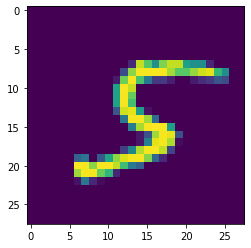

In [274]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j =20078     # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(mnist_trainset.data[j]),mnist_trainset.targets[j])

In [275]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=250,shuffle=True, num_workers=2)

In [276]:
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=250,shuffle=False, num_workers=2)

In [277]:
mnist_trainset.data.shape

torch.Size([47000, 28, 28])

In [278]:
classes = ('zero', 'one')

In [279]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [280]:
images[:4].shape

torch.Size([4, 1, 28, 28])

In [281]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

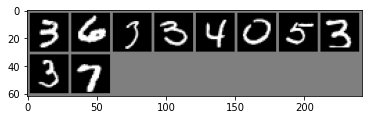

GroundTruth:    one  zero   one  zero   one  zero   one   one   one  zero


In [282]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [283]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)
    self.fc4 = nn.Linear(10,2)

  def forward(self,z):  
    y1 = self.pool(F.relu(self.conv1(z)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    # print(y1.shape)
    y1 = y1.view(-1, 16 * 4 * 4)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 

In [284]:
inc = Module2()
inc = inc.to("cuda")

In [285]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)

In [286]:
acti = []
loss_curi = []
for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    if (np.mean(ep_lossi)<=0.03):
        break
#         acti.append(actis)
    
            

print('Finished Training')

[1,    50] loss: 0.697
[1,   100] loss: 0.692
[1,   150] loss: 0.690
[2,    50] loss: 0.684
[2,   100] loss: 0.676
[2,   150] loss: 0.666
[3,    50] loss: 0.657
[3,   100] loss: 0.653
[3,   150] loss: 0.651
[4,    50] loss: 0.645
[4,   100] loss: 0.646
[4,   150] loss: 0.642
[5,    50] loss: 0.639
[5,   100] loss: 0.638
[5,   150] loss: 0.634
[6,    50] loss: 0.630
[6,   100] loss: 0.628
[6,   150] loss: 0.628
[7,    50] loss: 0.627
[7,   100] loss: 0.627
[7,   150] loss: 0.620
[8,    50] loss: 0.620
[8,   100] loss: 0.617
[8,   150] loss: 0.613
[9,    50] loss: 0.616
[9,   100] loss: 0.616
[9,   150] loss: 0.614
[10,    50] loss: 0.612
[10,   100] loss: 0.618
[10,   150] loss: 0.612
[11,    50] loss: 0.614
[11,   100] loss: 0.610
[11,   150] loss: 0.610
[12,    50] loss: 0.612
[12,   100] loss: 0.610
[12,   150] loss: 0.611
[13,    50] loss: 0.609
[13,   100] loss: 0.608
[13,   150] loss: 0.611
[14,    50] loss: 0.609
[14,   100] loss: 0.609
[14,   150] loss: 0.609
[15,    50] loss: 0

In [287]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 60000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 60000 train images: 98 %


In [288]:
total,correct

(47000, 46426)

In [289]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 20 %


In [290]:
out = np.concatenate(out,axis=0)

In [291]:
pred = np.concatenate(pred,axis=0)

In [292]:
index = np.logical_or(out ==1,out==0)
print(index.shape)

(10000,)


In [293]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100*acc))

Accuracy of the network on the 10000 test images: 98 %


In [294]:

sum(index)

2115

In [295]:
import random
random.sample([1,2,3,4,5,6,7,8],5)

[4, 7, 8, 3, 5]

In [296]:
# torch.save(inc.state_dict(),"/content/drive/My Drive/model_simple_8000.pkl")

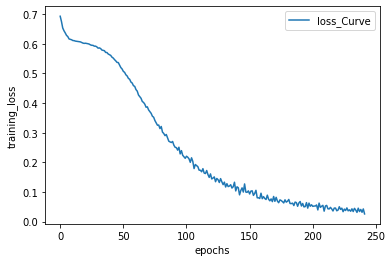

In [297]:
fig = plt.figure()
plt.plot(loss_curi,label="loss_Curve")
plt.xlabel("epochs")
plt.ylabel("training_loss")
plt.legend()
fig.savefig("loss_curve.pdf") 

Simple Model 3 Inception Module

|true training data  | Corr Training Data | Test Accuracy | Test Accuracy 0-1 | 
| ------------------ | ------------------ | ------------- | ----------------- |
| 100   | 47335  | 15  |  75 |
| 500   | 47335  | 16  |  80 | 
| 1000  | 47335  | 17  | 83  | 
| 2000  | 47335  | 19 | 92 | 
| 4000  | 47335  | 20 | 95  | 
| 6000  | 47335  |  20 | 96  | 
| 8000  | 47335  | 20  |  96 | 
| 12665 | 47335  | 20 | 98  | 


|   Total Training Data       |   Training Accuracy      |
|---------------------------- | ------------------------ |
| 47435         | 100 |
| 47835         | 100 |
| 48335         | 100 |
| 49335         | 100 | 
| 51335         | 100 |
| 53335         | 100 |
| 55335         | 100 |
| 60000         | 100 |

Mini- Inception network 8 Inception Modules

|true training data  | Corr Training Data | Test Accuracy | Test Accuracy 0-1 | 
| ------------------ | ------------------ | ------------- | ----------------- |
| 100   | 47335  | 14  | 69  |
| 500   | 47335  | 19  | 90  | 
| 1000  | 47335  | 19  |  92 | 
| 2000  | 47335  | 20  | 95  | 
| 4000  | 47335  | 20  |  97 | 
| 6000  | 47335  | 20  | 97  | 
| 8000  | 47335  | 20  |  98 | 
| 12665 | 47335  | 20  | 99  | 

|   Total Training Data       |   Training Accuracy      |
|---------------------------- | ------------------------ |
| 47435         | 100 |
| 47835         | 100 |
| 48335         | 100 |
| 49335         | 100 | 
| 51335         | 100 |
| 53335         | 100 |
| 55335         | 100 |
| 60000         | 100 |